In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import time
from IPython import display
from IPython.display import Audio  # To play sound/music, esp. when notebook finishes running!

import emcee
import corner
import batman

import gc  # Garbage collection
import time as t

from scipy.interpolate import RectBivariateSpline
from astropy.table import Table, Column

from matplotlib.ticker import MaxNLocator

pi = np.pi

In [2]:
'''Load Data'''
def get_data(folderdata):
    path = folderdata + '/ch2_datacube_binned_AORs579.dat'
    
    #Loading Data
    flux     = np.loadtxt(path, usecols=[0], skiprows=1)     # photon count
    flux_err = np.loadtxt(path, usecols=[1], skiprows=1)     # photon count
    time     = np.loadtxt(path, usecols=[2], skiprows=1)     # hours
    xdata    = np.loadtxt(path, usecols=[4], skiprows=1)     # pixel
    ydata    = np.loadtxt(path, usecols=[6], skiprows=1)     # pixel
    psfxwdat = np.loadtxt(path, usecols=[8], skiprows=1)     # pixel
    psfywdat = np.loadtxt(path, usecols=[10], skiprows=1)    # pixel
    
    factor   = 1/(np.median(flux))
    flux     = factor*flux
    flux_err = factor*flux
    return flux, flux_err, time, xdata, ydata, psfxwdat, psfywdat

<class 'numpy.ndarray'>
20.1354876736
1288


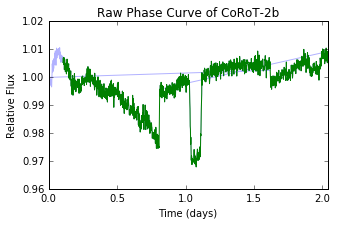

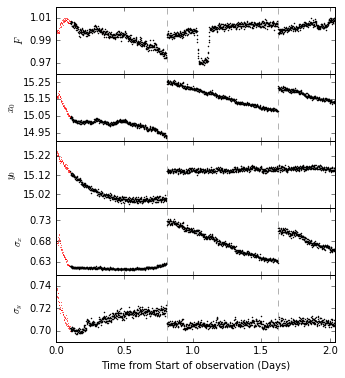

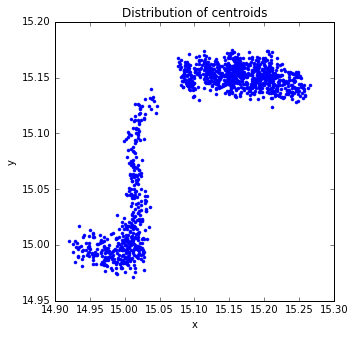

In [3]:
'''Get Data'''
foldername = 'Run4'
flux0, flux_err0, time0, xdata0, ydata0, psfxw0, psfyw0 = get_data(foldername)
flux, flux_err, time, xdata, ydata, psfxw, psfyw = get_data(foldername)

print(type(time))
'''Sort array chronologically'''
index    = np.argsort(time)
time     = time[index]
flux     = flux[index]
flux_err = flux_err[index]
xdata    = xdata[index]
ydata    = ydata[index]
psfxw    = psfxw[index]
psfyw    = psfyw[index]

'''Chop the first 2.5 hours'''

print(np.min(time))
ind = np.where(time>np.min(time)+2.5/24.0)
print(len(flux[ind]))

index    = np.argsort(time)
time     = time[ind]
flux_err = flux_err[ind]
flux     = flux[ind]
xdata    = xdata[ind]
ydata    = ydata[ind]
psfxw    = psfxw[ind]
psfyw    = psfyw[ind]

'''Convert time into BMJD'''
#timeMJD  = Time(time  + 57370.649060411, format = 'mjd', scale = 'utc')
#timeMJD0 = Time(time0 + 57370.649060411, format = 'mjd', scale = 'utc')

#timeJD   = (timeMJD.tdb).jd - 2454833
#timeJD0  = (timeMJD0.tdb).jd - 2454833


'''Convert to orbital phase'''

#timep  = (time-t0_mcmc[0])/per
#timep0 = (time0-t0_mcmc[0])/per

#timeaor1 = (21.75729537037037-t0_mcmc[0])/per
#timeaor2 = (20.94602719907407-t0_mcmc[0])/per

'''Convert time to start of observation'''

start = np.min(time0)

timeaor1 = 21.75729537037037 - np.min(time0)
timeaor2 = 20.94602719907407 - np.min(time0)

time  = time - np.min(time0)
time0 = time0 - np.min(time0)

'''Convert to AOR cuts to start of observation'''

#timep  = (time-t0_mcmc[0])/per
#timep0 = (time0-t0_mcmc[0])/per

#timeaor1 = (21.75729537037037-t0_mcmc[0])/per
#timeaor2 = (20.94602719907407-t0_mcmc[0])/per

'''Plot'''

plt.figure(figsize=(5,3))
plt.plot(time0, flux0, markersize=2, alpha = 0.3)
plt.plot(time, flux, markersize=2)
plt.xlim(np.min(time0), np.max(time0))
plt.title('Raw Phase Curve of CoRoT-2b')
plt.xlabel('Time (days)')
plt.ylabel('Relative Flux')

fig, axes = plt.subplots(5, 1, sharex=True, figsize=(5, 6))
#fig.suptitle("CoRoT-2b Observation")

axes[0].plot(time0[index], flux0[index],  'r.', markersize=1, alpha = 0.7)
axes[0].plot(time, flux,  'k.', markersize=2, alpha = 1.0)
axes[0].set_ylabel("$F$")
axes[0].set_xlim((np.min(time0), np.max(time0)))
axes[0].set_yticks(np.arange(0.97, 1.01, 0.02))
axes[0].axvline(x=timeaor1, color ='k', alpha=0.3, linestyle = 'dashed')
axes[0].axvline(x=timeaor2, color ='k', alpha=0.3, linestyle = 'dashed')

axes[1].plot(time0[index], xdata0[index],  'r.', markersize=1, alpha = 0.7)
axes[1].plot(time, xdata,  'k.', markersize=2, alpha = 1.0)
axes[1].set_ylabel("$x_0$")
axes[1].set_yticks(np.arange(14.95, 15.25, 0.1))
axes[1].axvline(x=timeaor1, color ='k', alpha=0.3, linestyle = 'dashed')
axes[1].axvline(x=timeaor2, color ='k', alpha=0.3, linestyle = 'dashed')

axes[2].plot(time0[index], ydata0[index],  'r.', markersize=1, alpha = 0.7)
axes[2].plot(time, ydata, 'k.', markersize=2, alpha = 1.0)
axes[2].set_ylabel("$y_0$")
axes[2].set_yticks(np.arange(15.02, 15.30, 0.1))
axes[2].set_ylim((14.95, 15.3))
axes[2].axvline(x=timeaor1, color ='k', alpha=0.3, linestyle = 'dashed')
axes[2].axvline(x=timeaor2, color ='k', alpha=0.3, linestyle = 'dashed')

axes[3].plot(time0[index], psfxw0[index],  'r.', markersize=1, alpha = 0.7)
axes[3].plot(time, psfxw, 'k.', markersize=2, alpha = 1.0)
axes[3].set_ylabel("$\sigma _x$")
axes[3].set_yticks(np.arange(0.63, 0.77, 0.05))
axes[3].set_ylim((0.6, 0.76))
axes[3].axvline(x=timeaor1, color ='k', alpha=0.3, linestyle = 'dashed')
axes[3].axvline(x=timeaor2, color ='k', alpha=0.3, linestyle = 'dashed')

axes[4].plot(time0[index], psfyw0[index],  'r.', markersize=1, alpha = 0.7)
axes[4].plot(time, psfyw,  'k.', markersize=2, alpha = 1.0)
axes[4].set_ylabel("$\sigma _y$")
axes[4].set_ylim((0.69, 0.75))
axes[4].set_yticks(np.arange(0.70, 0.74, 0.02))
axes[4].set_xlabel('Time from Start of observation (Days)')
axes[4].axvline(x=timeaor1, color ='k', alpha=0.3, linestyle = 'dashed')
axes[4].axvline(x=timeaor2, color ='k', alpha=0.3, linestyle = 'dashed')

fig.subplots_adjust(hspace=0)

#fig.tight_layout()
pathplot1 = foldername + '/MCMC_BLISS_1.pdf'
fig.savefig(pathplot1, bbox_inches='tight')

plt.figure(figsize=(5,5))
plt.plot(xdata,ydata,'.')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Distribution of centroids')

# Astrophysical Model

- Transit = stellar flux
- $F_p$ = $\Phi (t)$ x $(E(t)-1)$

In [4]:
def phase_variation2(time, t_sec, per, A, B, C, D):
    # in this model, we want A+B < 1/sqrt(2) = 0.707
    #t = time - t0 + per/2
    t = time - t_sec
    w = 2*np.pi/per
    phase = 1 + A*(np.cos(w*t)-1) + (B*np.sin(w*t)) + C*(np.cos(2*w*t)-1) + (D*np.sin(2*w*t))
    return phase

def transit_model(time, t0, per, rp, a, inc, ecc, w, u1, u2):
    params = batman.TransitParams()                      #object to store transit parameters
    params.t0 = t0                                       #time of inferior conjunction
    params.per = per                                     #orbital period
    params.rp = rp                                       #planet radius (in units of stellar radii)
    params.a = a                                         #semi-major axis (in units of stellar radii)
    params.inc = inc                                     #orbital inclination (in degrees)
    params.ecc = ecc                                     #eccentricity
    params.w = w                                         #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"                       #limb darkening model
    params.u = [u1, u2]                                  #limb darkening coefficients

    m = batman.TransitModel(params, time)                #initializes model
    flux = m.light_curve(params)
    t_secondary = m.get_t_secondary(params)
    return flux, t_secondary

def eclipse(time, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec):
    params = batman.TransitParams()                      #object to store transit parameters
    params.t0 = t0                                       #time of inferior conjunction
    params.per = per                                     #orbital period
    params.rp = rp                                       #planet radius (in units of stellar radii)
    params.a = a                                         #semi-major axis (in units of stellar radii)
    params.inc = inc                                     #orbital inclination (in degrees)
    params.ecc = ecc                                     #eccentricity
    params.w = w                                         #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"                       #limb darkening model
    params.u = [u1, u2]                                  #limb darkening coefficients
    params.fp = fp                                       #planet/star brightnes
    params.t_secondary = t_sec
    #params.t_secondary = params.t0+(params.per/2.0)
    
    m = batman.TransitModel(params, time, transittype="secondary")  #initializes model
    flux = m.light_curve(params)
    return flux

def fplanet_model2(time, A, B, C, D, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec):
    phase = phase_variation2(time, t_sec, per, A, B, C, D)
    eclip = eclipse(time, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec)
    flux = phase*(eclip - 1)
    return flux

def ideal_lightcurve2(time, t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D):
    # retransformation
    ecc = np.sqrt(ecosw**2 + esinw**2)
    w   = np.arctan(esinw/ecosw)
    u1  = 2*np.sqrt(q1)*q2
    u2  = np.sqrt(q1)*(1-2*q2)
    # create transit first and use orbital paramater to get time of superior conjunction
    transit, t_sec = transit_model(time, t0, 1.7429964, rp, a, inc, ecc, w, u1, u2)
    # create light curve of the planet
    fplanet = fplanet_model2(time, A, B, C, D, t0, 1.7429964, rp, a, inc, ecc, w, u1, u2, fp, t_sec)
    # add both light curves
    f_total = transit + fplanet
    return f_total

In [5]:
'''Check whether phase variation is unphysical'''
'''def check_phase(time, t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B):
    ecc = np.sqrt(ecosw**2 + esinw**2)
    w   = np.arctan(esinw/ecosw)
    u1  = 2*np.sqrt(q1)*q2
    u2  = np.sqrt(q1)*(1-2*q2)
    params = batman.TransitParams()                      #object to store transit parameters
    params = batman.TransitParams()                      #object to store transit parameters
    params.t0 = t0                                       #time of inferior conjunction
    params.per = 1.7429964                               #orbital period
    params.rp = rp                                       #planet radius (in units of stellar radii)
    params.a = a                                         #semi-major axis (in units of stellar radii)
    params.inc = inc                                     #orbital inclination (in degrees)
    params.ecc = ecc                                     #eccentricity
    params.w = w                                         #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"                       #limb darkening model
    params.u = [u1, u2]                                  #limb darkening coefficients

    m = batman.TransitModel(params, time)                #initializes model
    flux = m.light_curve(params)
    t_sec = m.get_t_secondary(params)
    
    phase = phase_variation2(time, t_sec, per, A, B)
    check = any(phase < 0.0)
    return check'''

phi = np.linspace(-np.pi, np.pi, 2000)

def check_phase(F0, C1, D1, C2, D2):
    A0 = F0/2
    A1 = 2*C1/np.pi
    B1 = -2*D1/np.pi
    A2 = 3*C2/2
    B2 = -3*D2/2
    brit = A0 + A1*np.cos(phi) + B1*np.sin(phi) + A2*np.cos(2*phi) + B2*np.sin(2*phi)
    check = any(brit < 0.0)
    return check

In [6]:
'''Definition related to BLISS'''

def lh_axes_binning(x_o,y_o,b_n,n_data):
    '''
    Input:
        x_o    = x-centroids
        y_o    = y-centroids
        b_n    = number of bin along 1 axis
        n_data = number of data points
    '''
    # xy_C = bin counts, x_edg = x-edge of the bins, y_edg = y-edge of the bins
    #xy_C,x_edg,y_edg = np.histogram2d(x_o, y_o, bins = b_n, range = [[14.83175584508888, 15.481755046090806],
    #                                                                 [14.865542242704164, 15.390568705183858]])
    xy_C,x_edg,y_edg = np.histogram2d(x_o, y_o, bins = b_n)
    
    # get the coordinate of the knots = middle of the bin
    x_k = x_edg[1:] - 0.5*(x_edg[1:] - x_edg[0:-1])
    y_k = y_edg[1:] - 0.5*(y_edg[1:] - y_edg[0:-1])
    x_Knt,y_Knt = np.meshgrid(x_k,y_k)
    
    # get knots association in both direction
    l_b_x,h_b_x = lh_knot_ass(x_k,x_o,b_n,n_data)
    l_b_y,h_b_y = lh_knot_ass(y_k,y_o,b_n,n_data)
    
    '''
    Output:
        low_bx,high_bx,low_by,high_by = bound association of each knots (index)
        x_Knots,y_Knots               = coordinated of the knots
        BK_T                          = bin counts
        xEdg,yEdg                     = coordinates of edges of the bin
        xKmesh,yKmesh                 = meshigrid for the knots
    '''
    return l_b_x,h_b_x,l_b_y,h_b_y,x_k,y_k,xy_C,x_edg,y_edg,x_Knt,y_Knt


def lh_knot_ass(xy_k,xy_o,b_n,n_data):
    '''
    Input:
        xy_k   = coordinates of knots
        xy_o   = coordinates of centroids
        b_n    = number of bin along 1 axis
        n_data = number of data points
    '''
    # pre-finding points "outside" the knots
    bad_l_xy = (xy_o < xy_k[0])  
    bad_h_xy = (xy_o > xy_k[-1]) 
    
    # calculate the distance between x or y coordinate of each centroid to all knots
    mid_xy_cln = np.transpose(np.tile(xy_k,(n_data,1)))
    
    # lower knots associated
    diff_xy_cln = xy_o - mid_xy_cln
    diff_xy_cln[diff_xy_cln < 0] = (xy_k[-1] - xy_k[0])
    l_b_xy = np.argmin(diff_xy_cln**2.0,axis=0)
    
    # upper knots associated
    diff_xy_cln = mid_xy_cln - xy_o
    diff_xy_cln[diff_xy_cln < 0] = (xy_k[-1] - xy_k[0])
    h_b_xy = np.argmin(diff_xy_cln**2.0,axis=0)
    
    # tuning l_b_xy upper bound and vice versa
    l_b_xy[l_b_xy == b_n-1] = b_n-2  
    h_b_xy[h_b_xy == 0] = 1
    h_b_xy[h_b_xy == l_b_xy] += 1  # Avoiding same bin reference (PROBLEMS?)
    
    # manually extrapolating points "outside" the knots
    l_b_xy[bad_l_xy] = 0  
    h_b_xy[bad_l_xy] = 1
    l_b_xy[bad_h_xy] = b_n-2
    h_b_xy[bad_h_xy] = b_n-1
    
    '''
    Output:
        l_b_xy = index of upper and lower knots associated
        h_b_xy = index of upper and lower knots associated
    '''
    return l_b_xy,h_b_xy


def which_NNI(xy_Ct,l_b_x,h_b_x,l_b_y,h_b_y):  
    '''
    Input:
        xy_Ct  = bin counts
        l_b_x  = index of lower and lower x-knots associated
        h_b_x  = index of upper and lower x-knots associated
        l_b_y  = index of lower and lower y-knots associated
        h_b_y  = index of upper and lower y-knots associated
    '''
    # get mask for points surrounded by a bad knot (no centroid there!)
    bad_left  = np.logical_or(xy_Ct[l_b_y,l_b_x] == 0.1,xy_Ct[l_b_y,h_b_x] == 0.1)
    bad_right = np.logical_or(xy_Ct[h_b_y,l_b_x] == 0.1,xy_Ct[h_b_y,h_b_x] == 0.1)
    nni_mask  = np.logical_or(bad_left,bad_right)
    '''
    Output:
        nni_mask                 = mask the data that should be NNI
        np.logical_not(nni_mask) = mask the data that should be BLISS
    '''
    return nni_mask,np.logical_not(nni_mask)


def lh_bin_to_knot(x_k,y_k,l_b_x,h_b_x,l_b_y,h_b_y):
    '''
    Input:
        x_k    = coord of x-knots
        y_k    = coord of y-knots
        l_b_x  = index of lower and lower x-knots associated
        h_b_x  = index of upper and lower x-knots associated
        l_b_y  = index of lower and lower y-knots associated
        h_b_y  = index of upper and lower y-knots associated
    '''
    # turns index of knots into knots coordinates 
    l_x_K = x_k[l_b_x] 
    h_x_K = x_k[h_b_x]
    l_y_K = y_k[l_b_y]
    h_y_K = y_k[h_b_y]
    '''
    Output:
        l_x_K = coord of lower and lower x-knots associated
        h_x_K = coord of upper and lower x-knots associated
        l_y_K = coord of lower and lower y-knots associated
        h_y_K = coord of upper and lower y-knots associated
    '''
    return l_x_K,h_x_K,l_y_K,h_y_K


def bound_knot(x_o,y_o,l_b_x,h_b_x,l_b_y,h_b_y,l_x_K,h_x_K,l_y_K,h_y_K,n_data):
    '''
    Input:
        x_o    = coord of x-centroid
        y_o    = coord of y-centroid
        l_b_x  = index of lower and lower x-knots associated
        h_b_x  = index of upper and lower x-knots associated
        l_b_y  = index of lower and lower y-knots associated
        h_b_y  = index of upper and lower y-knots associated
        l_x_K  = coord of lower and lower x-knots associated
        h_x_K  = coord of upper and lower x-knots associated
        l_y_K  = coord of lower and lower y-knots associated
        h_y_K  = coord of upper and lower y-knots associated
        n_data = number of data points
    '''
    left = (x_o - l_x_K <= h_x_K - x_o)
    right = np.logical_not(left)
    bottom = (y_o - l_y_K <= h_y_K - y_o)
    top = np.logical_not(bottom)
    
    xo_B_i,yo_B_i  = np.zeros(n_data),np.zeros(n_data)
    xo_B_i[left]   = l_b_x[left]
    xo_B_i[right]  = h_b_x[right]
    yo_B_i[bottom] = l_b_y[bottom]
    yo_B_i[top]    = h_b_y[top]
    
    '''
    Output:
        xo_B_i = index of closest knot
        yo_B_i = index of closest knot
    '''
    return xo_B_i.astype(int),yo_B_i.astype(int)


def bliss_dist(x_o,y_o,l_x_K,h_x_K,l_y_K,h_y_K):
    '''
    Input:
        x_o    = coord of x-centroid
        y_o    = coord of y-centroid
        l_x_K  = coord of lower and lower x-knots associated
        h_x_K  = coord of upper and lower x-knots associated
        l_y_K  = coord of lower and lower y-knots associated
        h_y_K  = coord of upper and lower y-knots associated
    '''
    LLd = (h_x_K - x_o)*(h_y_K - y_o)
    LRd = (x_o - l_x_K)*(h_y_K - y_o)
    ULd = (h_x_K - x_o)*(y_o - l_y_K)
    URd = (x_o - l_x_K)*(y_o - l_y_K)
    '''
    Output:
        LLd = distance to lower-left  knot
        LRd = distance to lower-right knot
        ULd = distance to upper-left  knot
        URd = distance to upper-right knot
    '''
    return LLd,LRd,ULd,URd

In [7]:
# To only test NNI in the BLISS routine, a la Stevenson+2012 way for finding ideal mesh size
all_NNI_key = False  

In [8]:
'''Pre-computing D(xo,yo) associations'''

N_bin        = 10
N            = len(xdata)

low_bx,high_bx,low_by,high_by,x_Knots,y_Knots,BK_T,xEdg,yEdg,xKmesh,yKmesh = lh_axes_binning(xdata,ydata,N_bin,N)
    
# Avoir division error and y,x for vizualising and consistency
BK_T[BK_T == 0] = 0.1
tBK_T = np.transpose(BK_T) 

# Determine which will be interpolated and which will BLISS: Get mask for both methods
NNI,BLS = which_NNI(tBK_T,low_bx,high_bx,low_by,high_by)
    
# Knots separation
delta_xo,delta_yo = x_Knots[1] - x_Knots[0],y_Knots[1] - y_Knots[0]
    
# Converting knot index to knot coordinate
low_Kx,high_Kx,low_Ky,high_Ky = lh_bin_to_knot(x_Knots,y_Knots,low_bx,high_bx,low_by,high_by)
    
# get closest knot association
xNt_B_i,yNt_B_i = bound_knot(xdata,ydata,low_bx,high_bx,low_by,high_by,low_Kx,high_Kx,low_Ky,high_Ky,N)
    
# find distance to 4 associated knots
LL_dst,LR_dst,UL_dst,UR_dst = bliss_dist(xdata,ydata,low_Kx,high_Kx,low_Ky,high_Ky)
    
# Linear indexing for faster 'np.bincount' routine!
xNt_B_lin = xNt_B_i + (N_bin*yNt_B_i)  

# Create empty array for bliss
flux_bliss = np.zeros(len(time))

# For full MCMC: jumping in ALL knot parameters
mask_goodBKT  = (BK_T != 0.1)
tmask_goodBKT = (tBK_T != 0.1)  # The important version for [y,x] consistency
tot_goodK     = len(tBK_T[tmask_goodBKT])

# "True" detector values for theta, using knots computed with centroid noise.
# Kfl_true = perf_detect_model(xKmesh[tmask_goodBKT],yKmesh[tmask_goodBKT],C_UTin,tot_goodK)  # DCs_true
# Kfl_true = np.load(file_Name+'EMCEE_PBJ_true.npy')[6+(Cn_in+1)+Cn_out:-4]

print('N/K = %.2f' % (N/tot_goodK))

N/K = 33.89


In [9]:
'''To be defined after centroid association'''

def map_flux_avgQuick(data,ast,dxyi_lin):
    '''
    Input:
        data     = measurements
        ast      = astro model
        dxyi_lin = index of bin associated with
        tBK_T    = bin counts to get mean
    '''
    # Avg flux at each data knot
    dxy_map = ((np.bincount(dxyi_lin,weights=data/ast,
                            minlength=(N_bin*N_bin)).reshape((N_bin,N_bin)))/tBK_T)
    # Using [y,x] for consistency
    '''
    Output:
        dxy_map = average values at knots 
    '''
    return dxy_map  

def bliss_meth(n_data, b_flux, dxy_map): 
    '''
    Input:
        n_data   = number of measurements
        b_flux   = empty array that will contain BLISS values
        dxy_map  = sensitivity values at the knots
        LLd      = distance to lower-left  knot
        LRd      = distance to lower-right knot
        ULd      = distance to upper-left  knot
        URd      = distance to upper-right knot
    '''
    # weight knots values by distance to knots
    LL = dxy_map[low_by ,low_bx ]*LL_dst
    LR = dxy_map[low_by ,high_bx]*LR_dst
    UL = dxy_map[high_by,low_bx ]*UL_dst
    UR = dxy_map[high_by,high_bx]*UR_dst
    
    # BLISS points
    b_flux[BLS] = (LL[BLS] + LR[BLS] + UL[BLS] + UR[BLS])/(delta_xo*delta_yo)
    
    # Nearest Neighbor points
    b_flux[NNI] = dxy_map[yNt_B_i[NNI],xNt_B_i[NNI]]  
    '''
    Output:
        b_flux  = BLISS/NNI sensitivity values at each knots
    '''
    return b_flux

In [10]:
'''Initialize parameters'''

# Some variable def
r_star            = 0.902              # solar radius
r_sol2jup         = 0.10045            # jupiter radius in solar radius
r_sol2AU          = 214.93946938       # AU radius in solar radius
hrs2days          = 1/24.0             # hour in days

# Transit Parameters from Gillon 2010 (10 params)
t0   = 21.20997                        # initially in hrs
per  = 1.7429964                       # initially in days
rp   = 0.1682824                       # initially in jupiter radius
a    = 6.6863411                       # initially in AU
inc  = 87.87407627  
ecosw= 0.001                           # dimensionless [0,1]                   
esinw= 0.0001
q1   = 0.02
q2   = 0.1
fp   = 0.0043                           # eclipse depth in units of stellar flux

# Phase Variation Parameters (4 params)
A    = 0.429337
B    = 0.141823
C    = 0.116684
D    = 0.0580765

# Photometric Uncertainty
sigF = 0.001440975135957425

# Regroup into arrays
p0_astro = np.array([t0, rp, a, inc, ecosw, esinw, q1, q2, fp])
p0_phase = np.array([A, B, C, D])
p0       = np.array([t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, sigF])

In [19]:
'''Load Best fit from lower order'''

Result_MCMC = np.load('Run4/ResultMCMC_Poly3_var2_Params.npy')

'''Initialize parameters'''

# Transit Parameters from Gillon 2010 (10 params)
t0   = Result_MCMC['t0'][0,0]   # initially in hrs
per  = 1.7429964                      # initially in days
rp   = Result_MCMC['rp'][0,0]         # initially in jupiter radius
a    = Result_MCMC['a'][0,0]          # initially in AU
inc  = Result_MCMC['inc'][0,0]
ecosw= Result_MCMC['ecosw'][0,0]      # dimensionless [0,1]                   
esinw= Result_MCMC['esinw'][0,0]
q1   = Result_MCMC['q1'][0,0]
q2   = Result_MCMC['q2'][0,0]
fp   = Result_MCMC['fp'][0,0]

# Phase Variation Parameters (2 params)
A    = Result_MCMC['A'][0,0]
B    = Result_MCMC['B'][0,0]
C    = Result_MCMC['C'][0,0]
D    = Result_MCMC['D'][0,0]

# uncertainty
#sigF = Result_MCMC['sigF'][0,0]

# pre-calculation
mid_x = np.mean(xdata)
mid_y = np.mean(ydata)

# Regroup into arrays
p0_astro = np.array([t0, rp, a, inc, ecosw, esinw, q1, q2, fp])
p0_phase = np.array([A, B])

p0 = np.array([t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, sigF])

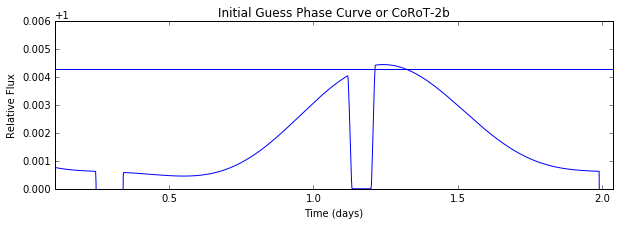

In [12]:
'''Creating initial guess for astro model'''
A_m = ideal_lightcurve2(time, t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D)

plt.figure(figsize=(10,3))
plt.plot(time, A_m)
plt.xlim(np.min(time), np.max(time))
plt.ylim(1, 1.006)
plt.axhline(y=fp+1)
plt.title('Initial Guess Phase Curve or CoRoT-2b')
plt.xlabel('Time (days)')
plt.ylabel('Relative Flux')

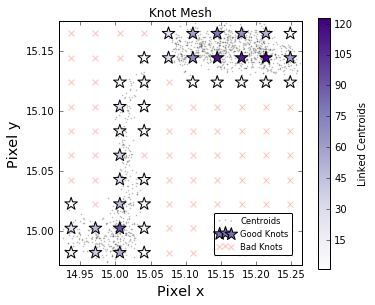

In [13]:
'''Second plot is Bliss map not residuals'''

Y_d = flux

fB_avg = map_flux_avgQuick(Y_d,A_m,xNt_B_lin)
#F_avg = map_flux_jumped(Dxy_Solo,Kfl_true)  # Uniform [Y,X] solved the problem! Will JUMP-sampler run better...?
#minviz = np.amin(F_avg[tmask_goodBKT])
#maxviz = np.amax(F_avg[tmask_goodBKT])

# star_colrs = np.zeros((tot_goodK,4))
# star_colrs[:,:3] = np.array([0,0.75,1])
star_colrs = tBK_T[tmask_goodBKT]  # [:,3]  /np.amax(tBK_T[tmask_goodBKT])

secs_in_hr = 3600.0
plt.figure(figsize=(12,6))

# plt.subplot2grid((2,5),(0,2),rowspan=2,colspan=3)
plt.subplot(121)
plt.scatter(xdata,ydata,color=(0,0,0),alpha=0.2,s=2,marker='.')  # s=10
# plt.scatter(xNt_vals[BLS],yNt_vals[BLS],color=(0,0,0),alpha=0.25,s=10,marker='.')
# plt.scatter(xNt_vals[NNI],yNt_vals[NNI],color=(0.5,0,0),alpha=0.25,s=10,marker='.')
plt.gca().set_aspect((x_Knots[-1]-x_Knots[0])/(y_Knots[-1]-y_Knots[0]))
# plt.xticks([])
plt.xlabel('Pixel x',size='x-large');
plt.ylabel('Pixel y',size='x-large');
plt.title('Knot Mesh',size='large')
plt.xlim([x_Knots[0] - 0.5*delta_xo,x_Knots[-1] + 0.5*delta_xo])
plt.ylim([y_Knots[0] - 0.5*delta_yo,y_Knots[-1] + 0.5*delta_yo])
plt.locator_params(axis='x',nbins=8)
plt.locator_params(axis='y',nbins=8)
my_stars = plt.scatter(xKmesh[tmask_goodBKT],yKmesh[tmask_goodBKT],c=star_colrs,cmap=cm.Purples,
            edgecolor='k',marker='*',s=175,vmin=1)  # (0,0.75,1), s=250
plt.colorbar(my_stars,label='Linked Centroids',shrink=0.75)
plt.scatter(xKmesh[tmask_goodBKT == False],yKmesh[tmask_goodBKT == False],color=(1,0.75,0.75),
            marker='x',s=35)  #,alpha=0.25)  # (0,0.375,0.5), s=50
legend = plt.legend(('Centroids','Good Knots','Bad Knots'),loc='lower right',bbox_to_anchor=(0.975,0.025),
           fontsize='small',fancybox=True)  # loc='lower right',bbox_to_anchor=(0.975,0.025)
legend.legendHandles[1].set_color(cm.Purples(0.67)[:3])
legend.legendHandles[1].set_edgecolor('black')

# New correct normalization by number of knots- duh! (Thanks Kevin)
#print('(B - Re)/sigma_noise values')
#this_wavg = np.sum(B_PJdiff[tmask_goodBKT]*tBK_T[tmask_goodBKT])/N
#print('Mean = %.3f' % this_wavg)
#this_wvarA = np.sum(((B_PJdiff[tmask_goodBKT] - this_wavg)**2.0)*tBK_T[tmask_goodBKT])
#this_wvarB = N/((N**2.0) - np.sum(tBK_T[tmask_goodBKT]**2.0))
#this_wstd = (this_wvarA*this_wvarB)**0.5
#print('STD = %.3f' % this_wstd)

In [14]:
'''def bliss_meth(n_data,b_flux,dxy_map,x_o,y_o):  # # GOOD VERSION!!!!!!!!!!!
#     b_flux[:] = 0  # Probably unnecessary?
    LL = dxy_map[low_by,low_bx]*LL_dst  # Using [y,x] for consistency
    LR = dxy_map[low_by,high_bx]*LR_dst
    UL = dxy_map[high_by,low_bx]*UL_dst
    UR = dxy_map[high_by,high_bx]*UR_dst
    b_flux[BLS] = (LL[BLS] + LR[BLS] + UL[BLS] + UR[BLS])/(delta_xo*delta_yo)  # BLISS points
    b_flux[NNI] = dxy_map[yNt_B_i[NNI],xNt_B_i[NNI]]  # Nearest Neighbor points
#     b_flux = n_data*b_flux/np.sum(b_flux)  # Normalizing as above
    return b_flux'''
print('.')

.


In [15]:
SigF_key = False
Cov_key  = False


In [23]:
cyc_typeB = 0  # Iterator for B-type knot repository; dummy initializing here
'''Simplified likelihood function'''
def data_like(p0, time, flux, n_data, knot_arch, orig, xNt_B_lin):
    global cyc_typeB
    # unpack p0
    t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, flux_err = p0
    # define model 
    astro_model = ideal_lightcurve2(time, t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D)
    sens_map = map_flux_avgQuick(flux,astro_model,xNt_B_lin)
    # save knots values at each step
    #holdontoknots_Btype(cyc_typeB,knot_arch,sens_map,orig)
    cyc_typeB += 1
    # calculate new detector model (BLISS)
    d_model = bliss_meth(n_data,flux_bliss,sens_map)
    # likelihood function
    model = astro_model*d_model
    inv_sigma2 = 1.0/(flux_err**2)
    lnlike = -0.5*(np.sum((flux-model)**2*inv_sigma2) - len(flux)*np.log(inv_sigma2))
    # line below if you want to fit for uncertainty on flux
    # lnlike = -n_data*np.log(sF) - 0.5*np.sum((numer/sF)**2.0) 
    return lnlike

In [24]:
'''Data Prior'''
def data_prior(p0):
    t0, rp, a, inc, ecosw, esinw, q1, q2, fp, A, B, C, D, flux_err = p0
    check = check_phase(1-A-C, A, B, C, D)
    # gaussian prior for a
    lgpri_a = -0.5*(((a - 6.70)/0.03)**2.0)
    # gaussian prior for i
    lgpri_i = -0.5*(((inc - 87.84)/0.1)**2.0)
    if (1.05 < t0 < 1.1 and 0 < rp < 1 and 0 < fp < 1 and 0 < q1 < 1 and 0 < q2 < 1 and 
        -0.707 < A < 0.707 and -0.407 < B < 0.407 and -0.707 < C < 0.707 and 
        -0.407 < D < 0.407 and -1 < ecosw < 1 and -1 < esinw < 1 and check == False):
        return 0.0 + lgpri_a + lgpri_i
    return -np.inf

In [25]:
'''Data Posterior'''
def data_post(p0, time, flux, n_data, knot_arch, orig, xNt_B_lin):
    global cyc_typeB
    # only useful when fitting for uncertainties
    #if sig_below_Zero(theta) == True:
    #    if run_type == 'B':  # Assume non-Cov. runs for now
    #        if knot_switch == True:
    #          knot_arch[cyc_typeB,:] = knot_arch[cyc_typeB-nwalkersB,:]
    #            holdontoknots_Btype(cyc_typeB,knot_arch,bogus_ssmap,orig)  # Saving B-type knots
    #           cyc_typeB += 1
    #    return -np.inf
    # discard step because and restore priors to be that of the previous step
    # basically does not accept the jump
    lgpri = data_prior(p0)
    if not np.isfinite(lgpri):
        #holdontoknots_Btype(cyc_typeB,knot_arch,bogus_ssmap,orig)  # Saving B-type knots
        cyc_typeB += 1
        return -np.inf
    return lgpri + data_like(p0, time, flux, n_data, knot_arch, orig, xNt_B_lin)

In [39]:
accep_B_check = 0  # Diagnostic double-check for acceptance number; dummy initializing here

# (Hopefully) Correctly making list of B-Type knots during emcee run!
def holdontoknots_Btype(cycle,knot_arch,ss_map,orig):
    global accep_B_check
    w = int(cycle % nwalkersB)  # walker number
    i = int((cycle - w)/nwalkersB)  # emcee step number
    if i == 0:
        temp_oldKB[w,:] = ss_map[tmask_goodBKT]  # Put 1st knots into 'old' array
    elif i == 1:
        temp_newKB[w,:] = ss_map[tmask_goodBKT]  # Put 2nd knots into 'new' array
    elif i == 2:  # First comparison is unique
        if np.all(orig[w,:] == samplerB.chain[w,i-2,:]):  # Check starting point and 1st chain entry for a match
            knot_arch[w,i-2,:] = temp_oldKB[w,:]  # Get 'old' if a match (rejected emcee step)
        else:
            knot_arch[w,i-2,:] = temp_newKB[w,:]  # Get 'new' if NOT a match (accepted emcee step)
            temp_oldKB[w,:] = temp_newKB[w,:]  # Move 'new' into 'old'
            accep_B_check += 1  # See top
        temp_newKB[w,:] = ss_map[tmask_goodBKT]  # Always end by putting current knots into 'new'
    else:  # All remaining comparisons
        if np.all(samplerB.chain[w,i-3,:] == samplerB.chain[w,i-2,:]):  # Check chain for matches
            knot_arch[w,i-2,:] = temp_oldKB[w,:]
        else:
            knot_arch[w,i-2,:] = temp_newKB[w,:]
            temp_oldKB[w,:] = temp_newKB[w,:]
            accep_B_check += 1
        temp_newKB[w,:] = ss_map[tmask_goodBKT]
    return  # Does require a final walker-loop after the chain completes (see emcee B-Type run)

In [20]:
'''Getting ready for MCMC'''
# instruction for sampling
ndimB, nwalkersB, nstep = len(p0), 500, 3000

# get scattered starting point in parameter space 
pos = [p0 + 10**(-5)*np.random.randn(ndimB) for i in range(nwalkersB)]

# what is this?
search_S = 2.5e3  # 2.5e3
pare_S = search_S/50  # /20

TwoPlus_key = False  # Meaning: Are you continuing a chain you just ran?

In [21]:
'''Running MCMC for BLISS'''
# Preparing BLISS Knot Repository
K_repo_typeB = np.zeros((nwalkersB,int(search_S),tot_goodK))
temp_oldKB,temp_newKB = np.zeros((nwalkersB,tot_goodK)),np.zeros((nwalkersB,tot_goodK))
cyc_typeB = 0  # Important: initializing iterator for knot archive
accep_B_check = 0  # Diagnostic iterator

# K_repo_typeB = np.zeros((nwalkersB*(search_S+1),tot_goodK))  # Because emcee runs an extra step

In [26]:
if TwoPlus_key == False:
    samplerB = emcee.EnsembleSampler(nwalkersB,ndimB,data_post,args=[time, flux, N, K_repo_typeB, pos, xNt_B_lin])
elif TwoPlus_key == True:
    samplerB = emcee.EnsembleSampler(nwalkersB,ndimB,data_post,args=[time, flux, N, K_repo_typeB, posB, xNt_B_lin])

In [43]:
'''Running MCMC'''
nstep = int(search_S)
#total_nstep = 


print("Running MCMC...")
tic = t.clock()
pos2, prob2, state2 = samplerB.run_mcmc(pos, nstep)
toc = t.clock()
print("Done.") 
print("time taken: ")
print(toc - tic)

Running MCMC...
Done.
time taken: 
3067.5216600106537


In [53]:
'''Running MCMC'''
nstep = int(search_S)
#total_nstep = 


print("Running MCMC...")
tic = t.clock()
pos, prob, state = samplerB.run_mcmc(pos2, 1000, rstate0=state2)
toc = t.clock()
print("Done.") 
print("time taken: ")
print(toc - tic)

Running MCMC...
Done.
time taken: 
631.912811875517


In [17]:
'''Save Chain'''
pathchain = foldername + '/samplerchainBliss_var2.npy'
pathposit = foldername + '/samplerposi_Bliss_var2.npy'
pathstate = foldername + '/samplerstateBliss_var2.npy'
np.save(pathchain, samplerB.chain[:,-2000:,:])
np.save(pathposit, pos)
#np.save(pathstate, np.asarray(state))

#samplerchain = np.load(pathchain)

In [28]:
'''print the results'''

samples = samplerB.chain[:,-2000:,:].reshape((-1, ndimB))
(t0_mcmc, rp_mcmc, a_mcmc, inc_mcmc, ecosw_mcmc, 
 esinw_mcmc, q1_mcmc, q2_mcmc, fp_mcmc, A_mcmc, B_mcmc, C_mcmc, D_mcmc, sigF_mcmc) = map(
    lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

print("""MCMC result:

    t0 = {0[0]} +{0[1]} -{0[2]} (Guess: {1})
    rp = {2[0]} +{2[1]} -{2[2]} (Gillon: {3})
    a = {4[0]} +{4[1]} -{4[2]} (Gillon: {5})
    inc = {6[0]} +{6[1]} -{6[2]} (Gillon: {7})
    ecosw = {8[0]} +{8[1]} -{8[2]} (Guess: {9})
    esinw = {10[0]} +{10[1]} -{10[2]} (Gillon: {11})
    q1 = {12[0]} +{12[1]} -{12[2]} (Gillon: {13})
    q2 = {14[0]} +{14[1]} -{14[2]} (Guess: {15})
    fp = {16[0]} +{16[1]} -{16[2]} (Guess: {17})
    
    A = {18[0]} +{18[1]} -{18[2]} (Guess: {19})
    B = {20[0]} +{20[1]} -{20[2]} (Guess: {21})
    C = {22[0]} +{22[1]} -{22[2]} (Guess: {23})
    D = {24[0]} +{24[1]} -{24[2]} (Guess: {25})
    sigF = {26[0]} +{26[1]} -{26[2]} (Guess: {25})
    
""".format(t0_mcmc, t0, rp_mcmc, rp, a_mcmc, a, inc_mcmc, inc, 
           ecosw_mcmc, ecosw, esinw_mcmc, esinw, q1_mcmc, q1, q2_mcmc, q2, fp_mcmc, fp,
           A_mcmc, A, B_mcmc, B, C_mcmc, C, D_mcmc, D, sigF_mcmc, sigF))


MCMC result:

    t0 = 1.074440236532089 +0.0001763297267096675 -0.00017481865939750207 (Guess: 21.20997)
    rp = 0.16860233281343714 +0.0009747883502749244 -0.0010100987724472044 (Gillon: 0.1682824)
    a = 6.683680077908774 +0.024448930157340065 -0.025024503166479306 (Gillon: 6.6863411)
    inc = 87.86940571693047 +0.0919942585643696 -0.09257730647817652 (Gillon: 87.87407627)
    ecosw = -6.9284622118463105e-06 +0.0004884173265359087 -0.00048747025989912137 (Guess: 0.001)
    esinw = -3.7318770592681297e-06 +0.0004925529489596934 -0.0004782900623296697 (Gillon: 0.0001)
    q1 = 0.01575228143295003 +0.023068816727297464 -0.010284538067332621 (Gillon: 0.02)
    q2 = 0.28743101395826265 +0.38523013062194567 -0.21317963665875203 (Guess: 0.1)
    fp = 0.004503946538422097 +0.00023544376862115555 -0.00023383666173147546 (Guess: 0.0043)
    
    A = 0.42202619374453076 +0.019832859141851567 -0.022332859788966042 (Guess: 0.429337)
    B = 0.1747960797621645 +0.045874934618838514 -0.04433249

In [29]:
def walk_style(ndim, nwalk, samples, interv, subsamp, labels):
    '''
    input:
        ndim    = number of free parameters
        nwalk   = number of walkers
        samples = samples chain
        interv  = take every 'interv' element to thin out the plot
        subsamp = only show the last 'subsamp' steps
    '''
    # get first index
    beg   = len(samples[0,:,0]) - subsamp
    end   = len(samples[0,:,0]) 
    step  = np.arange(beg,end)
    step  = step[::interv] 
    
    # number of columns and rows of subplots
    ncols = 4
    nrows = int(np.ceil(ndim/ncols))
    sizey = 2*nrows
    
    # plotting
    #plt.subplot(nrows, ncols, ind)
    #fig.tight_layout()
    plt.figure(figsize = (15, 2*nrows))
    for ind in range(ndim):
        plt.subplot(nrows, ncols, ind+1)
        # get indices for subplots
        #i = int(ind/ncols) # row number
        #j = ind % ncols    # col number
        # get mean and standard deviation
        mu_param = np.mean(samples[:,:,ind][:,beg:end:interv], axis = 0)
        std_param = np.std(samples[:,:,ind][:,beg:end:interv], axis = 0)
        plt.plot(step, mu_param)
        plt.fill_between(step, mu_param + 3*std_param, mu_param - 3*std_param, facecolor='k', alpha = 0.1)
        plt.fill_between(step, mu_param + 2*std_param, mu_param - 2*std_param, facecolor='k', alpha = 0.1)
        plt.fill_between(step, mu_param + 1*std_param, mu_param - 1*std_param, facecolor='k', alpha = 0.1)
        plt.title(labels[ind])
        plt.xlim(np.min(step), np.max(step))
        if ind < (ndim - ncols):
            plt.xticks([])
        else: 
            plt.xticks(rotation=25)
    return    

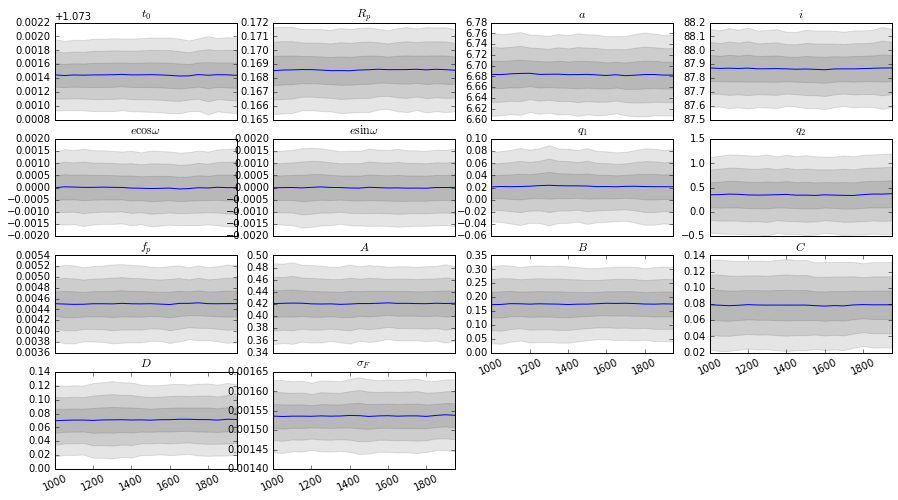

In [31]:
labels = np.array(['$t_0$','$R_p$','$a$','$i$','$e\cos \omega$', '$e \sin \omega$',
                     '$q_1$',r'$q_2$','$f_p$', '$A$', '$B$', '$C$', '$D$', '$\sigma _F$'], dtype='object_')

walk_style(14, nwalkersB, samplerB.chain, 50, 1000, labels)

In [32]:
res_lightcurve = ideal_lightcurve2(time, t0_mcmc[0], rp_mcmc[0], a_mcmc[0], 
                                   inc_mcmc[0], ecosw_mcmc[0], esinw_mcmc[0], q1_mcmc[0], q2_mcmc[0], 
                                   fp_mcmc[0], A_mcmc[0], B_mcmc[0], C_mcmc[0], D_mcmc[0])
res_sensmap    = map_flux_avgQuick(flux, res_lightcurve,xNt_B_lin)
res_det        = bliss_meth(len(flux),flux_bliss,res_sensmap)
signal_result  = res_lightcurve*res_det

In [33]:
maxind = np.where(res_lightcurve==np.max(res_lightcurve))

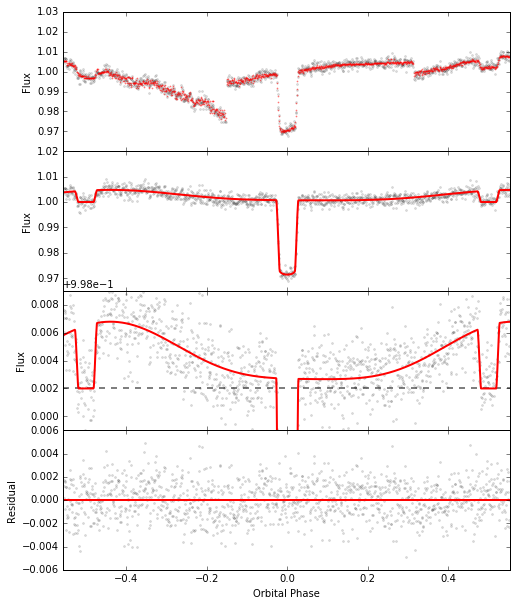

In [34]:
fig, axes = plt.subplots(ncols = 1, nrows = 4, sharex = True, figsize=(8, 10))
axes[0].set_xlim((np.min(time)-t0_mcmc[0])/per, (np.max(time)-t0_mcmc[0])/per)
axes[0].plot((time-t0_mcmc[0])/per, flux, '.', color = 'k', markersize = 4, alpha = 0.15)
axes[0].plot((time-t0_mcmc[0])/per, res_lightcurve*res_det, '.', color = 'r', markersize = 2.5, alpha = 0.4)
axes[0].set_yticks(np.arange(0.97, 1.03, 0.01))
axes[0].set_ylabel('Flux')

axes[1].plot((time-t0_mcmc[0])/per, flux/res_det, '.', color = 'k', markersize = 4, alpha = 0.15)
axes[1].plot((time-t0_mcmc[0])/per, res_lightcurve, color = 'r', linewidth=2)
axes[1].set_yticks(np.arange(0.97, 1.02, 0.01))
axes[1].set_ylabel('Flux')
#axes[1].set_ylim(0.995, 1.005)
#axes[1].axhline(y=1, color='b')
#axes[1].axhline(y=1+0.004231819514801176, color='b')
axes[2].axhline(y=1, color='k', linewidth = 2, linestyle='dashed', alpha = 0.5)
axes[2].plot((time-t0_mcmc[0])/per, flux/res_det, '.', color = 'k', markersize = 4, alpha = 0.15)
axes[2].plot((time-t0_mcmc[0])/per, res_lightcurve, color = 'r', linewidth=2)
axes[2].set_yticks(np.arange(0.998, 1.006, 0.002))
axes[2].set_ylabel('Flux')
axes[2].set_ylim(0.997, 1.007)

axes[3].plot((time-t0_mcmc[0])/per, flux/res_det - res_lightcurve, 'k.', markersize = 4, alpha = 0.15)
axes[3].axhline(y=0, color='r', linewidth = 2)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Orbital Phase')

fig.subplots_adjust(hspace=0)
plotname = foldername + '/MCMC_Bliss_var2_2.pdf'
fig.savefig(plotname, bbox_inches='tight')

In [35]:
def chi2(data, fit, err):
    N     = len(data)
    denom = (data - fit)**2
    numer = err**2
    chi2  = np.sum(denom/numer)
    return chi2

def loglikelihood(data, fit, err):
    inv_sigma2 = 1.0/(err**2)
    return -0.5*(np.sum((data-fit)**2*inv_sigma2 - np.log(inv_sigma2)))

def BIC(logL, Npar, Ndat):
    E = logL - (Npar/2)*np.log(Ndat)
    return E

ferr_fit = np.ones(len(flux))* sigF_mcmc[0]

data = (flux/res_det)
fit  = res_lightcurve
chisB = chi2(data, fit, ferr_fit)


print(chisB)
logLB = loglikelihood(data, fit, ferr_fit
                     )
print('Likelihood: ',logLB)
#EB = BIC(logLB, ndim, len(data))
#print('Evidence: ',EB)

1288.57534993
Likelihood:  7700.06661631


In [38]:
from astropy.stats import sigma_clip

def get_full_data(folderdata):
    path = folderdata + '/ch2_datacube_full_AORs579.dat'
    #Loading Data
    flux  = np.loadtxt(path, usecols=[0], skiprows=1)         # photon count
    flux_err = np.loadtxt(path, usecols=[1], skiprows=1)     # photon count
    time  = np.loadtxt(path, usecols=[2], skiprows=1)         # hours
    xdata = np.loadtxt(path, usecols=[3], skiprows=1)         # hours
    ydata = np.loadtxt(path, usecols=[4], skiprows=1)         # hours
    # scaling
    #factor = 1/(np.median(flux))
    #flux = factor*flux
    #flux_err = factor*flux
    return flux, flux_err, time, xdata, ydata 
    
'''Full Data'''
flux_full, ferr_full, time_full, x_full, y_full = get_full_data(foldername)

time_full = time_full - start

'''Order in chronological order'''
index = np.argsort(time_full)
flux_full = flux_full[index]
ferr_full = ferr_full[index]
time_full = time_full[index]
x_full    = x_full[index]
y_full    = y_full[index]

'''crop the first 2.5 hours'''
index = np.argsort(time_full)
flux_full = flux_full[70*64:]
ferr_full = ferr_full[70*64:]
time_full = time_full[70*64:]
x_full    = x_full[70*64:]
y_full    = y_full[70*64:]

'''Sigma clip per data cube'''
flux_clean = []
x_clean    = []
y_clean    = []

for i in range(1288):
    beg = int(i*64)
    end = int((i+1)*64)
    flux_clean = np.ma.append(flux_clean, sigma_clip(flux_full[beg:end]))
    x_clean = np.ma.append(x_clean, sigma_clip(x_full[beg:end]))
    y_clean = np.ma.append(y_clean, sigma_clip(y_full[beg:end]))

'''Normalize flux'''
flux_clean = flux_clean/np.ma.median(flux_clean)

# Computing best astro mode
lc_full  = ideal_lightcurve2(time_full, t0_mcmc[0], rp_mcmc[0], a_mcmc[0],
                             inc_mcmc[0], ecosw_mcmc[0], esinw_mcmc[0], q1_mcmc[0], 
                             q2_mcmc[0], fp_mcmc[0], A_mcmc[0], B_mcmc[0], C_mcmc[0], D_mcmc[0])

det_full        = np.repeat(res_det, 64)
det_full        = np.ma.masked_array(det_full, mask=(y_clean.mask+x_clean.mask))

model_full = det_full*lc_full

'''Get fitted Uncertainties'''
ferr_fit = np.ones(len(flux_clean))*sigF_mcmc[0]*np.sqrt(64)
#ferr_clean = np.ma.masked_array(ferr_clean, mask = model_full.mask)

N = len(model_full)-np.sum((model_full).mask)

chis = chi2(flux_clean, lc_full*det_full, ferr_fit)
print('$\chi ^2 = $',chis)
logL = loglikelihood(flux_clean, lc_full*det_full, ferr_fit)
print('$\ln(L)=$',logL)
#E = BIC(logL, ndim, len(flux_clean))
#print('$E =$', E)

C:\Users\Lisa\Anaconda3\lib\site-packages\astropy\stats\sigma_clipping.py:180: RuntimeWarning: invalid value encountered in greater
  _filtered_data.mask |= _filtered_data > max_value
C:\Users\Lisa\Anaconda3\lib\site-packages\astropy\stats\sigma_clipping.py:181: RuntimeWarning: invalid value encountered in less
  _filtered_data.mask |= _filtered_data < min_value


$\chi ^2 = $ 42405.9418417
$\ln(L)=$ 338357.009761


C:\Users\Lisa\Anaconda3\lib\site-packages\numpy\ma\core.py:852: RuntimeWarning: invalid value encountered in greater_equal
  return umath.absolute(a) * self.tolerance >= umath.absolute(b)


# Corner Plot

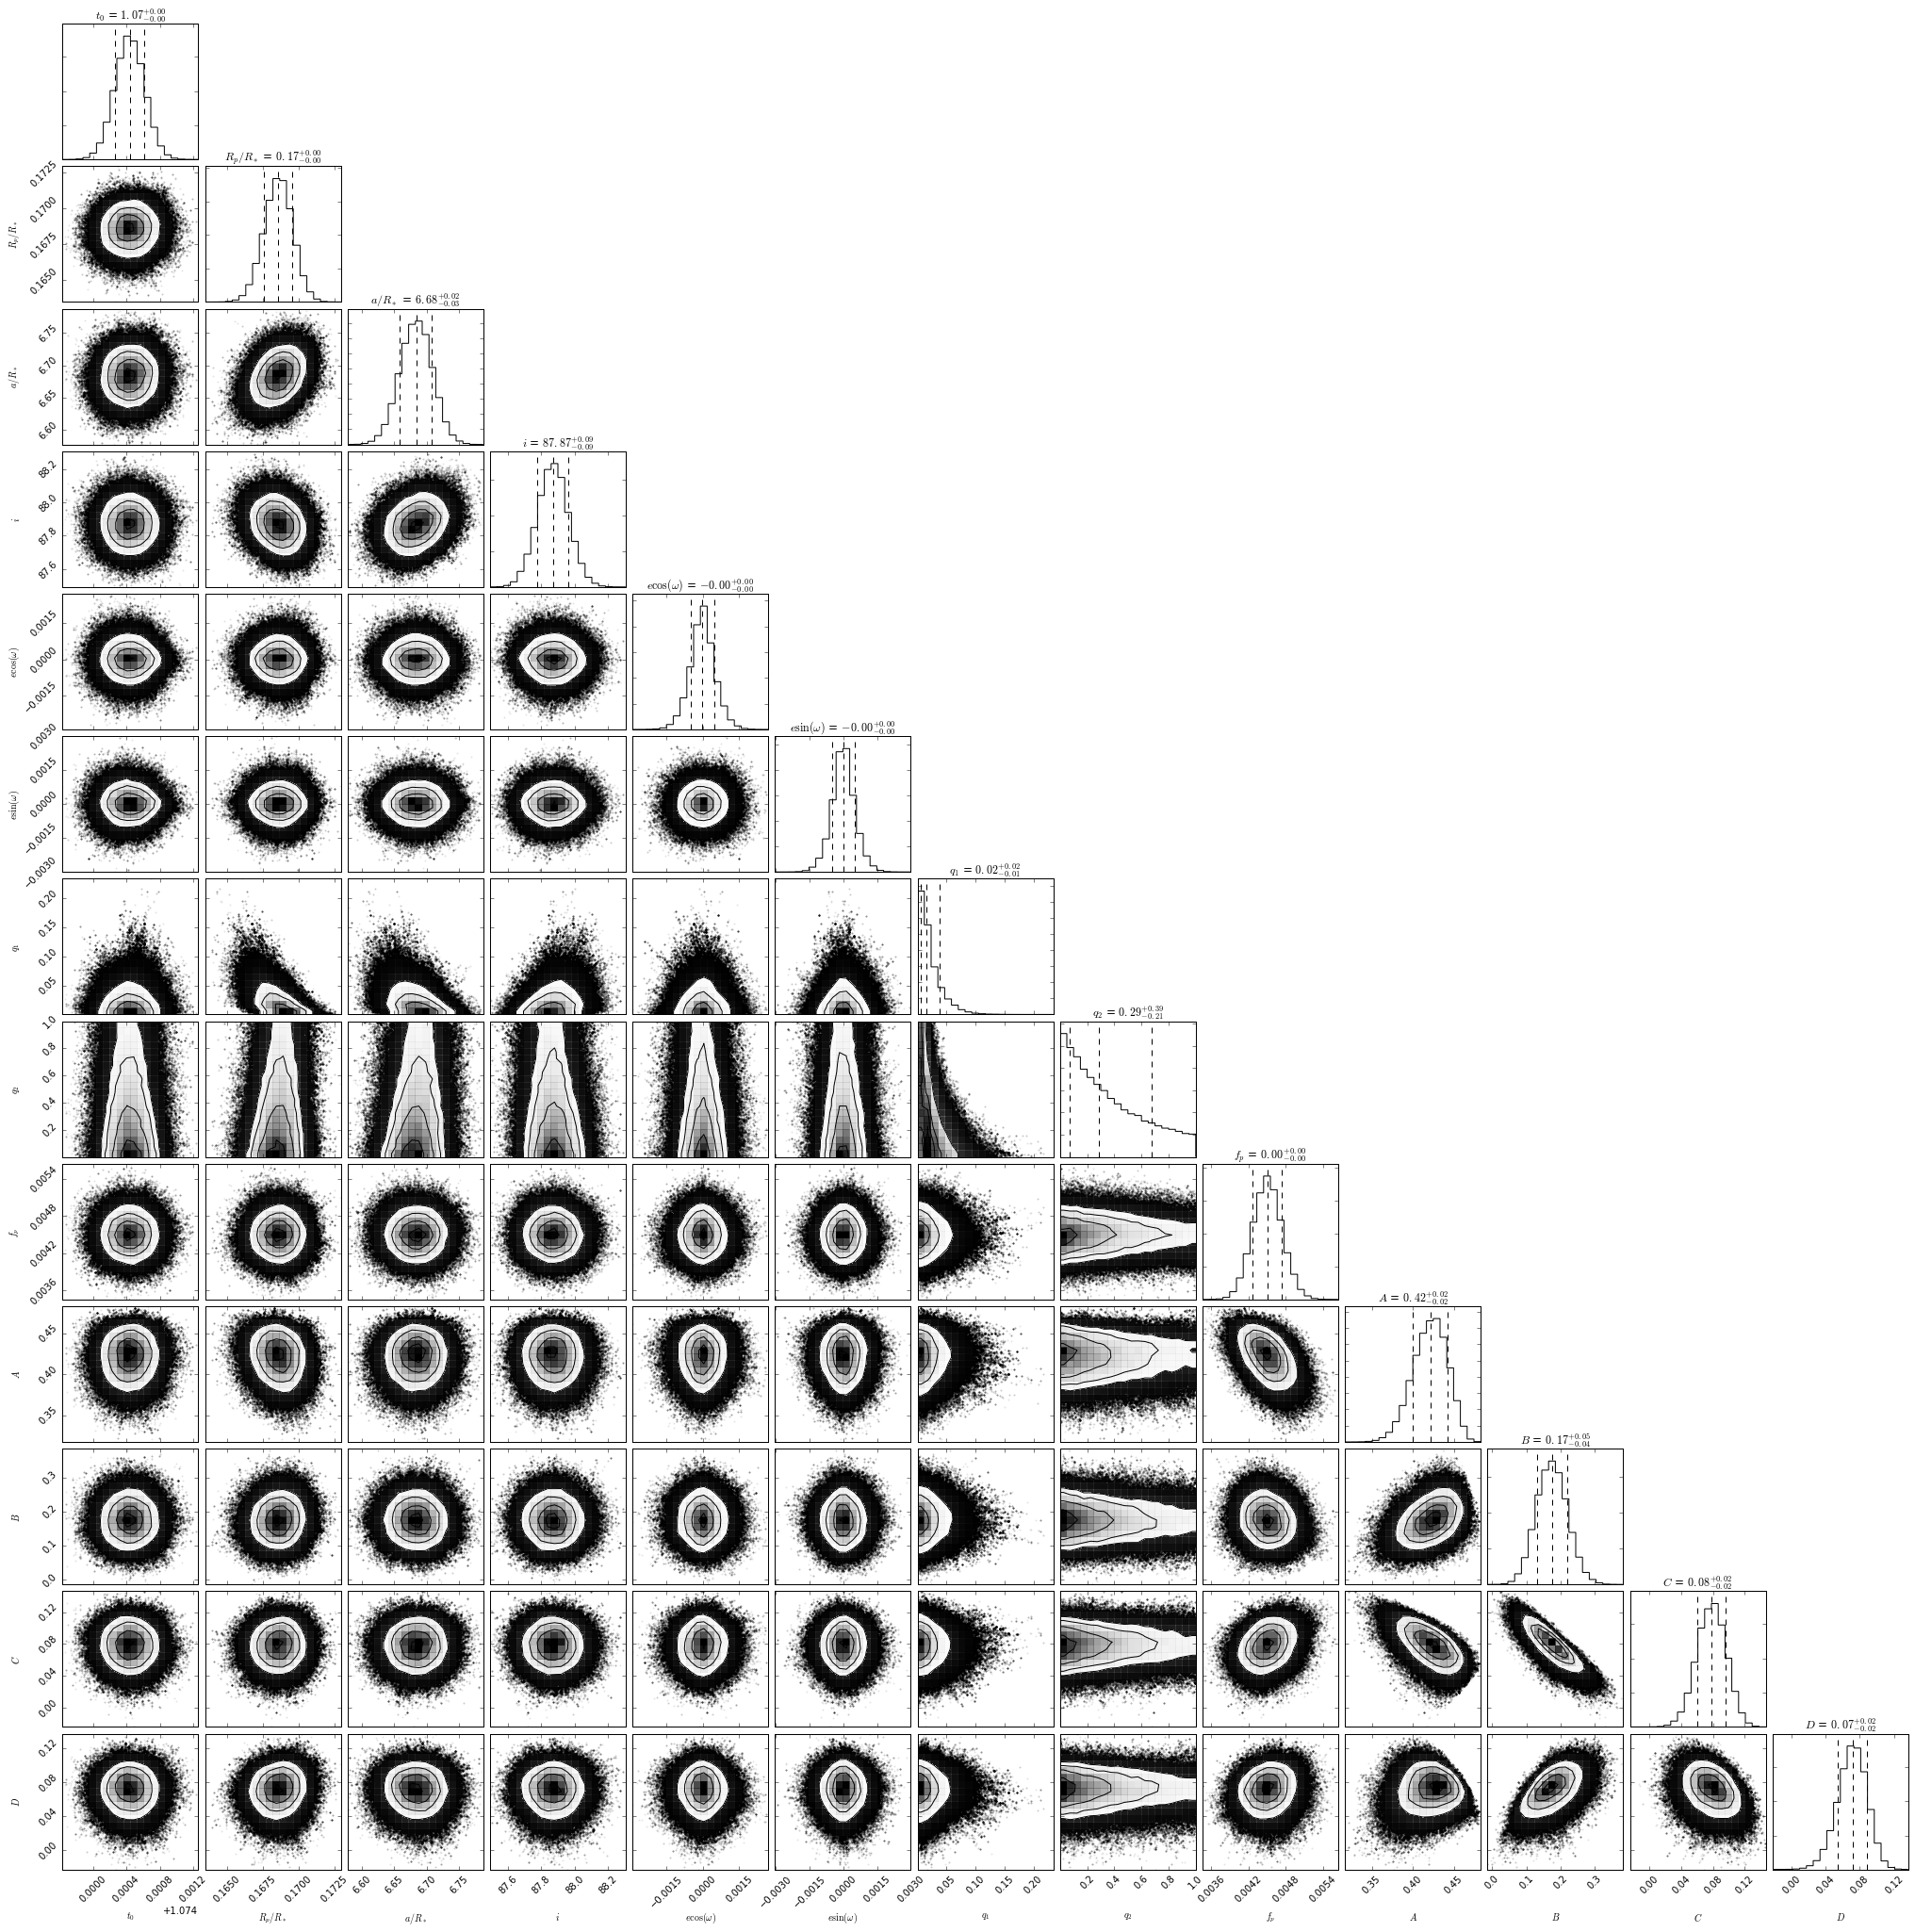

In [62]:
fig = corner.corner(samples[:,0:13], labels=["$t_0$","$R_p/R_*$", "$a/R_*$", "$i$",
                                             "$e \cos(\omega)$", "$e \sin(\omega)$", "$q_1$",
                                             "$q_2$", '$f_p$', '$A$', '$B$','$C$', '$D$'], 
                    quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12})
plotname = foldername + '/MCMC_Bliss_var2_3.pdf'
fig.savefig(plotname, bbox_inches='tight')

In [52]:
e_chain = np.sqrt(samples[:,4]**2 + samples[:,5]**2)
w_chain = np.arctan(samples[:,5]/samples[:,4])
u1_chain = 2*np.sqrt(samples[:,6]**2)*samples[:,7]
u2_chain = np.sqrt(samples[:,6]**2)*(1-2*samples[:,7])
binse = np.linspace(np.min(e_chain), np.max(e_chain), 20)
binsw = np.linspace(np.min(w_chain), np.max(w_chain), 20)
binsu1 = np.linspace(np.min(u1_chain), np.max(u1_chain), 20)
binsu2 = np.linspace(np.min(u2_chain), np.max(u2_chain), 20)

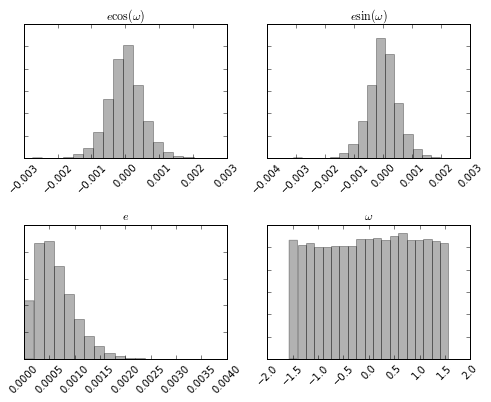

In [53]:
'''Eccentricity and Longitude of Periastron Coefficient'''
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8,6))
axes[0,0].hist(samples[:,4], bins=np.linspace(np.min(samples[:,4]), np.max(samples[:,4]), 20), color='k', alpha=0.3)
axes[0,1].hist(samples[:,5], bins=np.linspace(np.min(samples[:,5]), np.max(samples[:,4]), 20), color='k', alpha=0.3)
axes[1,0].hist(e_chain, binse, color='k', alpha=0.3)
axes[1,1].hist(w_chain, binsw, color='k', alpha=0.3)

plt.setp(axes[0,0].get_yticklabels(), visible=False)
plt.setp(axes[0,1].get_yticklabels(), visible=False)
plt.setp(axes[1,0].get_yticklabels(), visible=False)
plt.setp(axes[1,1].get_yticklabels(), visible=False)

plt.setp(axes[0,0].get_xticklabels(), rotation = 45)
plt.setp(axes[0,1].get_xticklabels(), rotation = 45)
plt.setp(axes[1,0].get_xticklabels(), rotation = 45)
plt.setp(axes[1,1].get_xticklabels(), rotation = 45)

axes[0,0].set_title('$e \cos (\omega)$', fontsize=12)
axes[0,1].set_title('$e \sin (\omega)$', fontsize=12)
axes[1,0].set_title('$e$', fontsize=12)
axes[1,1].set_title('$\omega$', fontsize=12)

fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.2)
plotname = foldername + '/MCMC_Bliss_var2_5.pdf'

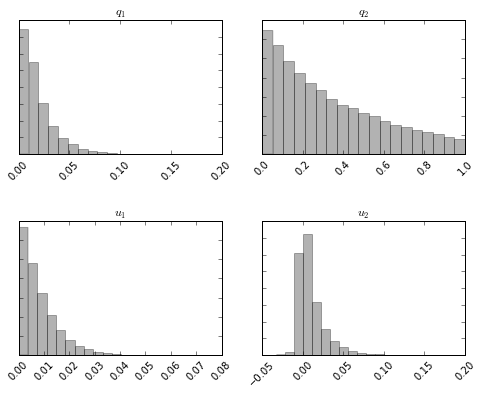

In [54]:
'''Eccentricity and Longitude of Periastron Coefficient'''
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (8,6))
axes[0,0].hist(samples[:,6], bins=np.linspace(np.min(samples[:,6]), np.max(samples[:,6]), 20), color='k', alpha=0.3)
axes[0,1].hist(samples[:,7], bins=np.linspace(np.min(samples[:,7]), np.max(samples[:,7]), 20), color='k', alpha=0.3)
axes[1,0].hist(u1_chain, binsu1, color='k', alpha=0.3)
axes[1,1].hist(u2_chain, binsu2, color='k', alpha=0.3)

plt.setp(axes[0,0].get_yticklabels(), visible=False)
plt.setp(axes[0,1].get_yticklabels(), visible=False)
plt.setp(axes[1,0].get_yticklabels(), visible=False)
plt.setp(axes[1,1].get_yticklabels(), visible=False)

plt.setp(axes[0,0].get_xticklabels(), rotation = 45)
plt.setp(axes[0,1].get_xticklabels(), rotation = 45)
plt.setp(axes[1,0].get_xticklabels(), rotation = 45)
plt.setp(axes[1,1].get_xticklabels(), rotation = 45)

axes[0,0].set_title('$q_1$', fontsize=12)
axes[0,1].set_title('$q_2$', fontsize=12)
axes[1,0].set_title('$u_1$', fontsize=12)
axes[1,1].set_title('$u_2$', fontsize=12)

fig.subplots_adjust(hspace=0.5)
fig.subplots_adjust(wspace=0.2)
plotname = foldername + '/MCMC_Bliss_var2_6.pdf'
fig.savefig(plotname, bbox_inches='tight')

In [55]:
def triangle_colors(data1, data2, data3, data4, bins, res, label):
    fig = plt.figure(figsize = (8,8))
    gs  = gridspec.GridSpec(len(data1)-1,len(data1)-1)
    i = 0
    for k in range(np.sum(np.arange(len(data1)))):
        j= k - np.sum(np.arange(i+1))
        ax = fig.add_subplot(gs[i,j])
        ax.plot(data1[j], data1[i+1],'k.', markersize = 0.5)
        l1 = ax.plot(data2[j], data2[i+1],'.', color = '#66ccff', markersize = 0.7, label='$1^{st}$ secondary eclipse')
        l2 = ax.plot(data3[j], data3[i+1],'.', color = '#ff9933', markersize = 0.7, label='transit')
        l3 = ax.plot(data4[j], data4[i+1],'.', color = '#0066ff', markersize = 0.7, label='$2^{nd}$ secondary eclipse')
        if (j == 0):
            plt.setp(ax.get_yticklabels(), rotation = 45)
            ax.yaxis.set_major_locator(MaxNLocator(5, prune = 'both'))
            ax.set_ylabel(label[i+1])
        else:
            plt.setp(ax.get_yticklabels(), visible=False)
        if (i == len(data1)-2):
            plt.setp(ax.get_xticklabels(), rotation = 45)
            ax.plot(bins[j], res[j], '.', color='#ff5050', markersize = 3)
            ax.xaxis.set_major_locator(MaxNLocator(5, prune = 'both'))
            ax.set_xlabel(label[j])
        else:
            plt.setp(ax.get_xticklabels(), visible=False)
        if(i == j):
            i += 1
    handles = [l1,l2,l3]
    fig.subplots_adjust(hspace=0)
    fig.subplots_adjust(wspace=0)
    #fig.legend(handles, ['$1^{st}$ secondary eclipse', 'transit', '$2^{nd}$ secondary eclipse'],bbox_to_anchor = [0.5, -0.05], loc = 'upper center')
    plotname = foldername + '/MCMC_Bliss_var2_4.pdf'
    fig.savefig(plotname, bbox_inches='tight')
    #fig.colorbar()

In [56]:
test = ideal_lightcurve2(time, t0_mcmc[0], rp_mcmc[0], a_mcmc[0], 
                                   inc_mcmc[0], ecosw_mcmc[0], esinw_mcmc[0], q1_mcmc[0], q2_mcmc[0], 
                                   fp_mcmc[0], 0, 0, 0, 0)
index = np.where(test != np.max(test))
ind_ecl1 = np.array([34,   35,   36,   37,   38,   39,   40,   41,   42,   43,   44,
         45,   46,   47,   48,   49,   50,   51,   52,   53,   54,   55,
         56,   57,   58,   59,   60,   61,   62,   63,   64,   65,   66,
         67,   68,   69,   70,   71,   72,   73,   74,   75,   76,   77,
         78,   79,   80,   81,   82,   83,   84,   85,   86,   87,   88,
         89,   90,   91,   92,   93,   94,   95,   96,   97])
ind_ecl2 = np.array([614,  615,
        616,  617,  618,  619,  620,  621,  622,  623,  624,  625,  626,
        627,  628,  629,  630,  631,  632,  633,  634,  635,  636,  637,
        638,  639,  640,  641,  642,  643,  644,  645,  646,  647,  648,
        649,  650,  651,  652,  653,  654,  655,  656,  657,  658,  659,
        660,  661,  662,  663,  664,  665,  666,  667,  668,  669,  670,
        671,  672,  673,  674,  675,  676,  677])
ind_tra = np.array([1195, 1196, 1197, 1198,
       1199, 1200, 1201, 1202, 1203, 1204, 1205, 1206, 1207, 1208, 1209,
       1210, 1211, 1212, 1213, 1214, 1215, 1216, 1217, 1218, 1219, 1220,
       1221, 1222, 1223, 1224, 1225, 1226, 1227, 1228, 1229, 1230, 1231,
       1232, 1233, 1234, 1235, 1236, 1237, 1238, 1239, 1240, 1241, 1242,
       1243, 1244, 1245, 1246, 1247, 1248, 1249, 1250, 1251, 1252, 1253,
       1254, 1255, 1256, 1257])

In [57]:
def binning_data(data, size):
    data = np.ma.masked_invalid(data) 
    reshaped_data   = data.reshape((len(data)/size, size))
    binned_data     = np.ma.median(reshaped_data, axis=1)
    binned_data_std = np.std(reshaped_data, axis=1)
    return binned_data

In [58]:
residual = flux/res_det - res_lightcurve

bin_x2, res_x2 = binning_data(xdata[:1350], 28), binning_data(residual[:1350],28)
bin_y2, res_y2 = binning_data(ydata[:1350], 28), binning_data(residual[:1350],28)
bin_sx2, res_sx2 = binning_data(psfxw[:1350], 28), binning_data(residual[:1350],28)
bin_sy2, res_sy2 = binning_data(psfyw[:1350],28), binning_data(residual[:1350],28)
bin_f2, res_f2 = binning_data(flux[:1350], 28), binning_data(residual[:1350],28)

res_bin2 = [res_x2, res_y2, res_sx2, res_sy2, res_f2]
bins2    = [bin_x2, bin_y2, bin_sx2, bin_sy2, bin_f2]

C:\Users\Lisa\Anaconda3\lib\site-packages\numpy\ma\core.py:4474: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result = self._data.reshape(*s, **kwargs).view(type(self))
C:\Users\Lisa\Anaconda3\lib\site-packages\numpy\ma\core.py:4478: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  result._mask = mask.reshape(*s, **kwargs)


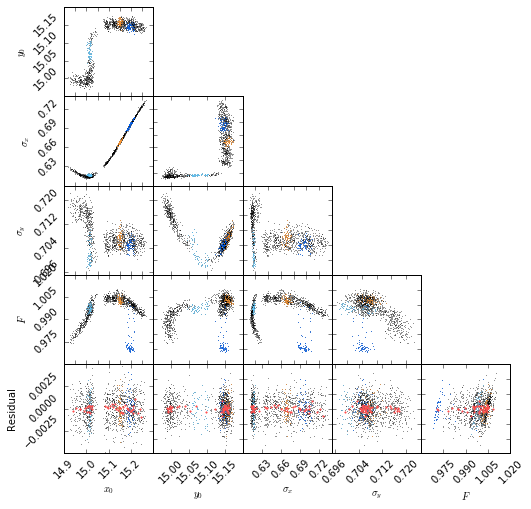

In [59]:
data1 = [xdata, ydata, psfxw, psfyw, flux, residual]
data2 = [xdata[ind_ecl1], ydata[ind_ecl1], psfxw[ind_ecl1], psfyw[ind_ecl1], flux[ind_ecl1], residual[ind_ecl1]]
data3 = [xdata[ind_tra], ydata[ind_tra], psfxw[ind_tra], psfyw[ind_tra], flux[ind_tra], residual[ind_tra]]
data4 = [xdata[ind_ecl2], ydata[ind_ecl2], psfxw[ind_ecl2], psfyw[ind_ecl2], flux[ind_ecl2], residual[ind_ecl2]]
label = ['$x_0$', '$y_0$', '$\sigma _x$', '$\sigma _y$', '$F$', 'Residual']

triangle_colors(data1, data2, data3, data4, bins2, res_bin2, label)

In [40]:
ResultMCMC_Params = Table()
ResultMCMC_Params['t0'] = [t0_mcmc]
ResultMCMC_Params['rp'] = [rp_mcmc]
ResultMCMC_Params['a'] = [a_mcmc] 
ResultMCMC_Params['inc'] = [inc_mcmc]
ResultMCMC_Params['ecosw'] = [ecosw_mcmc]
ResultMCMC_Params['esinw'] = [esinw_mcmc]
ResultMCMC_Params['q1'] = [q1_mcmc]
ResultMCMC_Params['q2'] = [q2_mcmc]
ResultMCMC_Params['fp'] = [fp_mcmc]

ResultMCMC_Params['A'] = [A_mcmc]
ResultMCMC_Params['B'] = [B_mcmc]
ResultMCMC_Params['C'] = [C_mcmc]
ResultMCMC_Params['D'] = [D_mcmc]

ResultMCMC_Params['sigF'] = [sigF_mcmc]

ResultMCMC_Params['chi2B'] = [chisB]
ResultMCMC_Params['logLB'] = [logLB]
#ResultMCMC_Params['evidenceB'] = [EB]

ResultMCMC_Params['chi2'] = [chis]
ResultMCMC_Params['logL'] = [logL]
#ResultMCMC_Params['evidence'] = [E]

pathres = foldername + '/ResultMCMC_Bliss_var2_Params.npy'
np.save(pathres, ResultMCMC_Params)